<img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;"> [Run In Google Colab](https://colab.research.google.com/github/themis-ai/capsa/blob/main/notebooks/1_Ensemble-Classification.ipynb)


# Tutorial: How to use capsa to detect bias and uncertainty 

## Background

Modern AI models show great promise in many different applications. But so far, we've focused on the most well-known metric as we think about AI models, it's **accuracy**. This is clearly very important metric that we use to understand how well AI behaves in general, and whether it has been sufficiently trained. But we are not seeing these highly accurate AI models in deployment in our everyday lives. Why are we not seeing fully autonomous cars yet? Why are we not letting AI solve our crucial problems?

This is because of the fundamental difference between how we define **accuracy**, and what we require in a trustworthy system:

If we are going to deploy an AI models to our most safety critical system, we expect these model to be accurate. But we also expect them to infer when they should be trusted with a decision, and when they should not. Current state of the art models do not include any trust metric with their predictions. And therefore, they are not deployable in safety critical applications.


## Defining trust (risk)

To trust an AI model, we need to define the metric it needs to output along with it's predictions. In general, we call these **risk metric**. But we can look at risk in 3 different categories. 



1. Representation Bias 
2. Epistemic Uncertainty (Model Uncertainty)
3. Aleatoric Uncertainty (Data Uncertainty)


## How capsa works

In this tutorial, we will learn how to levarage capsa's wrappers to make our models risk aware. `capsa` uses wrappers to augment a given model. Each capsa wrapper offers specific risk metrics, but it is possible to wrap a model with multiple wrappers to enhance the model's risk awareness capabilities. 

![Capsa overview](https://raw.githubusercontent.com/aamini/introtodeeplearning/2023/lab3/img/capsa_overview.png)

## Import

Let's get started by installing the necessary dependencies:

In [1]:
# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package for visualization
!pip install git+https://github.com/aamini/introtodeeplearning.git@2023
import mitdeeplearning as mdl

# Download and import capsa
!pip install capsa
import capsa

  Cloning https://github.com/aamini/introtodeeplearning.git (to revision 2023) to /tmp/pip-req-build-6wq21lt8
  Running command git clone -q https://github.com/aamini/introtodeeplearning.git /tmp/pip-req-build-6wq21lt8
  Running command git checkout -b 2023 --track origin/2023
  Switched to a new branch '2023'
  Branch '2023' set up to track remote branch '2023' from 'origin'.
  Resolved https://github.com/aamini/introtodeeplearning.git to commit ed7501323f5b3f0f865db898b1ce6a0528df1586


## Dataset

For the purpose of this tutorial, we are focusing on the facial detection problem. We have a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces).

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale dataset (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). A large-scale dataset with many images across many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose and mitigate potential issues with *bias, fairness, and confidence*. This will be a larger test dataset for evaluation purposes.

We begin by importing these datasets. For the purpose of this tutorial, we have a `DatasetLoader` class that does a bit of data pre-processing to import the training data in a usable format.

In [2]:
batch_size = 64

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face_2023_perturbed_small.h5', 'https://www.dropbox.com/s/tbra3danrk5x8h5/train_face_2023_perturbed_small.h5?dl=1')
# Instantiate a DatasetLoader using the downloaded dataset
train_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=True, batch_size=batch_size)
test_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=False, batch_size=batch_size)

Opening /home/egedemir/.keras/datasets/train_face_2023_perturbed_small.h5
Loading data into memory...
Opening /home/egedemir/.keras/datasets/train_face_2023_perturbed_small.h5
Loading data into memory...


## Building robustness to bias and uncertainty

Remember that we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. We want to mitigate the effects of unwanted bias and uncertainty on the model's predictions and performance. Our goal is to build the best-performing, most robust model, one that achieves high classification accuracy across the entire test dataset.

To achieve this, we are back to considering the three metrics introduced with capsa: (1) representation bias, (2) data or aleatoric uncertainty, and (3) model or epistemic uncertainty. Note that all three of these metrics are different! For example, we can have well-represented examples that still have high epistemic uncertainty.

## Detecting bias with Capsa

Capsa can be used to learn the latent structure of a database and uncover feature representation disparities, inspired by the approach of [uncover hidden biases](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf). As long as we have a predefined model, capsa can do this in one line!

This sets the foundation for quantifying a key risk metric -- representation bias -- for the facial detection problem. In working to improve your model's performance, you will want to consider representation bias carefully and think about how you could mitigate the effect of representation bias.

We will begin by defining a standard CNN-based classifier. We will then use Capsa to wrap the model and build the risk-aware variant.

In [3]:
### Define the CNN classifier model ###

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1, n_filters=12):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(64,64, 3)),
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=8*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model



## Capsa's `HistogramVAEWrapper`

With our base classifier, Capsa allows us to automatically define a VAE implementing that base classifier. Capsa's [`HistogramVAEWrapper`](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html) builds this VAE to analyze the latent space distribution. 

Specifically, `capsa.HistogramVAEWrapper` constructs a histogram with `num_bins` bins across every dimension of the latent space, and then calculates the joint probability of every sample according to the constructed histograms. The samples with the lowest joint probability have the lowest representation; the samples with the highest joint probability have the highest representation.

`capsa.HistogramVAEWrapper` takes in a number of arguments including:
1. `base_model`: the model to be transformed into the risk-aware variant.
2. `num_bins`: the number of bins we want to discretize our distribution into. 
2. `queue_size`: the number of samples we want to track at any given point.
3. `decoder`: the decoder architecture for the VAE.

HistogramVAEWrapper also has model reversing functionality. Therefore, we don't have to pass it a decoder. It can simply reverse the base_model to generate a decoder. But for the sake of this tutorial, let's predefine a decoder as well.


In [ ]:
### Define the decoder architecture for the facial detection VAE ###

def make_face_decoder_network(n_filters=12):
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, 
                                      padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=2*2*8*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(2, 2, 8*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=6*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

We are ready to create the wrapped model using `capsa.HistogramVAEWrapper` by passing in the relevant arguments!

We can take our standard CNN classifier, wrap it with `capsa.HistogramVAEWrapper`, and build the wrapped model. The wrapper then enablings semi-supervised training for the facial detection task. As the wrapped model trains, the classifier weights are updated, and the VAE-wrapped model learns to track feature distributions over the latent space. More details of the `HistogramVAEWrapper` and how it can be used are [available here](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html).

We can then evaluate the representation bias of the classifier on the test dataset. By calling the `wrapped_model` on our test data, we can automatically generate representation bias and uncertainty scores that are normally manually calculated. Let's wrap our base CNN classifier using Capsa, train and build the resulting model, and start to process the test data: 

In [6]:
### Estimating representation bias with Capsa HistogramVAEWrapper ###

model = make_standard_classifier()
# Wrap the CNN classifier for latent encoding with a VAE wrapper
wrapped_model = capsa.HistogramVAEWrapper(model, num_bins=5, queue_size=20000, 
    latent_dim = 32, decoder=make_face_decoder_network())

# Build the model for classification, defining the loss function, optimizer, and metrics
wrapped_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # for classification
    metrics=[tf.keras.metrics.BinaryAccuracy()], # for classification
    run_eagerly=True
)

# Train the wrapped model for 6 epochs by fitting to the training data
history = wrapped_model.fit(
        train_loader,
        epochs=6,
        batch_size=batch_size,
  )

## Evaluation

# Get all faces from the testing dataset
test_imgs = test_loader.get_all_faces()

# Call the Capsa-wrapped classifier to generate outputs: predictions, uncertainty, and bias!
predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)

Epoch 1/6
686/686 [==============================] - 6s 6ms/step - vae_compiled_loss: 0.4760 - vae_compiled_binary_accuracy: 0.7507 - vae_wrapper_loss: 467.4131
Epoch 2/6
686/686 [==============================] - 4s 6ms/step - vae_compiled_loss: 0.3192 - vae_compiled_binary_accuracy: 0.8651 - vae_wrapper_loss: 240.0266
Epoch 3/6
686/686 [==============================] - 4s 7ms/step - vae_compiled_loss: 0.3024 - vae_compiled_binary_accuracy: 0.8763 - vae_wrapper_loss: 204.8112
Epoch 4/6
686/686 [==============================] - 4s 6ms/step - vae_compiled_loss: 0.2914 - vae_compiled_binary_accuracy: 0.8838 - vae_wrapper_loss: 192.2929
Epoch 5/6
686/686 [==============================] - 4s 6ms/step - vae_compiled_loss: 0.2910 - vae_compiled_binary_accuracy: 0.8847 - vae_wrapper_loss: 180.7966
Epoch 6/6
9/9 [==============================] - 1s 80ms/step


## Analyzing representation bias with Capsa

From the above output, we have an estimate for the representation bias score! We can analyze the representation scores to start to think about manifestations of bias in the facial detection dataset.

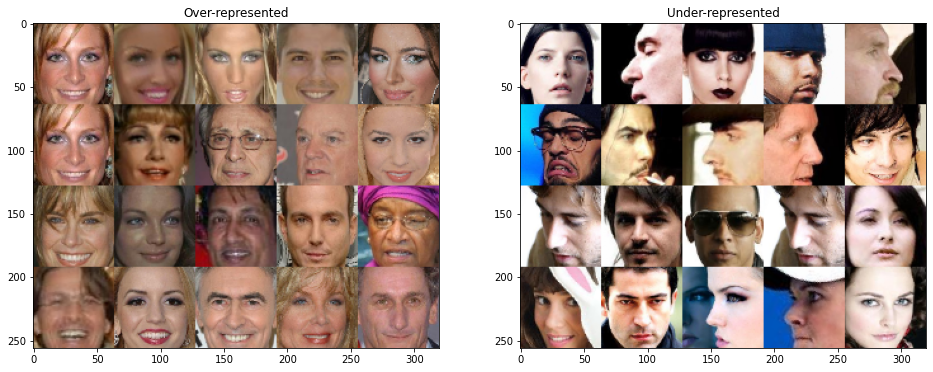

In [7]:
### Analyzing representation bias scores ###

# Sort according to lowest to highest representation scores
indices = np.argsort(bias, axis=None) # sort the score values themselves
sorted_images = test_imgs[indices] # sort images from lowest to highest representations
sorted_biases = bias[indices] # order the representation bias scores
sorted_preds = predictions[indices] # order the prediction values


# Visualize the 20 images with the lowest and highest representation in the test dataset
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(sorted_images[-20:], (4, 5)))
ax[0].set_title("Over-represented")

ax[1].imshow(mdl.util.create_grid_of_images(sorted_images[:20], (4, 5)))
ax[1].set_title("Under-represented");

We can also quantify how the representation density relates to the classification accuracy by plotting the two against each other:

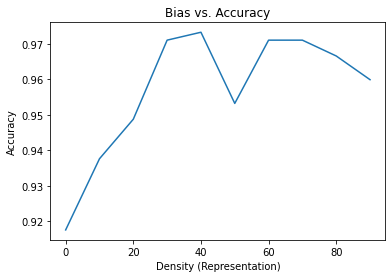

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot the representation density vs. the accuracy
plt.xlabel("Density (Representation)")
plt.ylabel("Accuracy")
averaged_imgs = mdl.lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")

These representations scores relate back to data examples, so we can visualize what the average face looks like for a given *percentile* of representation density:

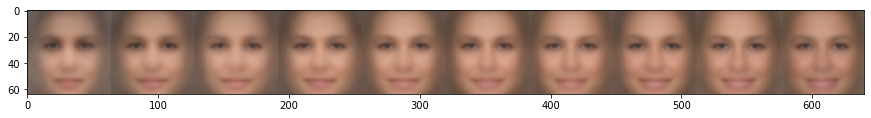

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(mdl.util.create_grid_of_images(averaged_imgs, (1,10)))

## Analyzing epistemic uncertainty with Capsa

*Epistemic* uncertainty, or a model's uncertainty in its prediction, can arise from out-of-distribution data, missing data, or samples that are harder for the model to learn. This does not necessarily correlate with representation bias! Imagine the scenario of training an object detector for self-driving cars: even if the model is presented with many cluttered scenes, these samples still may be harder to learn than scenes with very few objects in them.

We will now use our VAE-wrapped facial detection classifier to analyze and estimate the epistemic uncertainty of the model trained on the facial detection task.

While most methods of estimating epistemic uncertainty are *sampling-based*, we can also use ***reconstruction-based*** methods -- like using VAEs -- to estimate epistemic uncertainty. If a model is unable to provide a good reconstruction for a given data point, it has not learned that area of the underlying data distribution well, and therefore has high epistemic uncertainty.



Since we've already used the `HistogramVAEWrapper` to calculate the histograms for representation bias quantification, we can use the exact same VAE wrapper to shed insight into epistemic uncertainty! Capsa helps us do exactly that. When we called the model, we returned the classification prediction, uncertainty, and bias for every sample:
`predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)`.

Let's analyze these estimated uncertainties:

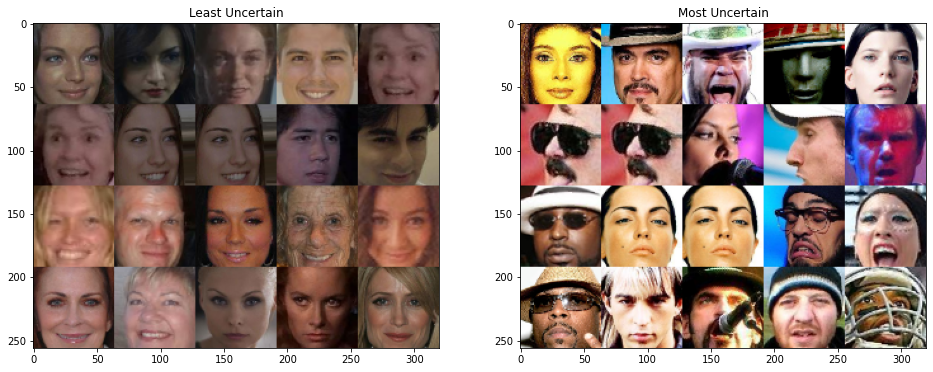

In [10]:
### Analyzing epistemic uncertainty estimates ###

# Sort according to epistemic uncertainty estimates
epistemic_indices = np.argsort(uncertainty, axis=None) # sort the uncertainty values
epistemic_images = test_imgs[epistemic_indices] # sort images from lowest to highest uncertainty
sorted_epistemic = uncertainty[epistemic_indices] # order the uncertainty scores
sorted_epistemic_preds = predictions[epistemic_indices] # order the prediction values


# Visualize the 20 images with the LEAST and MOST epistemic uncertainty
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(epistemic_images[:20], (4, 5)))
ax[0].set_title("Least Uncertain");

ax[1].imshow(mdl.util.create_grid_of_images(epistemic_images[-20:], (4, 5)))
ax[1].set_title("Most Uncertain");

We quantify how the epistemic uncertainty relates to the classification accuracy by plotting the two against each other:

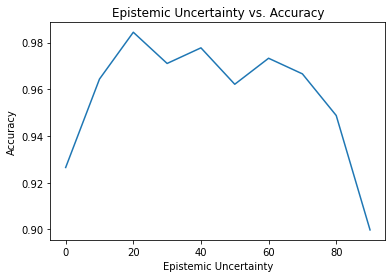

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot epistemic uncertainty vs. classification accuracy
plt.xlabel("Epistemic Uncertainty")
plt.ylabel("Accuracy")
_ = mdl.lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

# Measuring and reducing Aleatoric uncertainty

In [16]:
### Estimating aleatoric uncertainty with the MVE Wrapper ###

mve_model = make_standard_classifier()
# Wrap the CNN classifier for latent encoding with an MVE wrapper
mve_model = capsa.MVEWrapper(mve_model, is_classification=True)

# Build the model for classification, defining the loss function, optimizer, and metrics
mve_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # for classification
    metrics=[tf.keras.metrics.BinaryAccuracy()], # for classification
    run_eagerly=True
)

# Train the wrapped model for 6 epochs by fitting to the training data
history = mve_model.fit(
        train_loader,
        epochs=2,
        batch_size=batch_size,
  )

Epoch 1/2
686/686 [==============================] - 3s 4ms/step - mve_compiled_loss: 0.5043 - mve_compiled_binary_accuracy: 0.7900 - mve_wrapper_loss: 0.7807
Epoch 2/2
686/686 [==============================] - 3s 5ms/step - mve_compiled_loss: 2.2225 - mve_compiled_binary_accuracy: 0.6650 - mve_wrapper_loss: 3.0741


In [17]:
# Evaluation
# Get all faces and nonfaces from both the test and the train datasets
face_images = np.vstack((test_loader.get_all_faces(), train_loader.get_all_faces()))
nonface_images = np.vstack(((test_loader.images[test_loader.neg_train_inds] / 255.0).astype(np.float32), \
                  (train_loader.images[train_loader.neg_train_inds] / 255.0).astype(np.float32)))

#get the predictions and variance on the Capsa-wrapped classifier
mve_face_predictions = mve_model(face_images)
mve_nonface_predictions = mve_model(nonface_images)

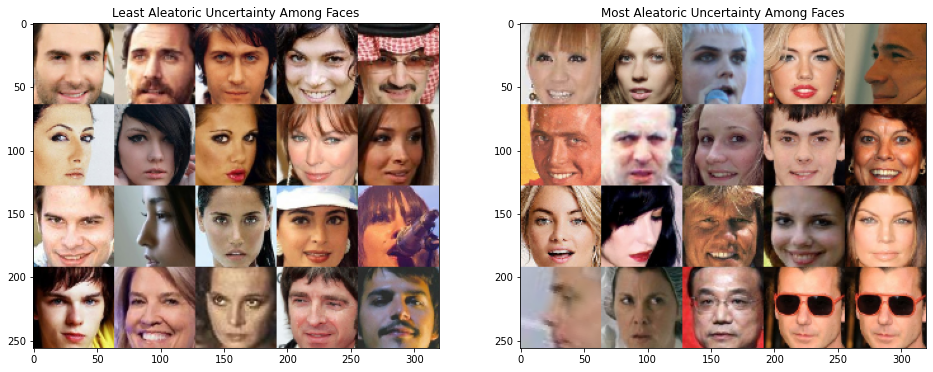

In [ ]:
face_predictions = mve_face_predictions.y_hat
face_aleatorics = mve_face_predictions.aleatoric
nonface_predictions = mve_nonface_predictions.y_hat
nonface_aleatorics = mve_face_predictions.aleatoric


# Sort according to aleatoric uncertainty estimates
face_aleatoric_indices = np.argsort(face_aleatorics, axis=None) # sort the uncertainty values
aleatoric_face_images = face_images[face_aleatoric_indices] # sort images from lowest to highest uncertainty
sorted_aleatoric_faces = [face_aleatorics[x] for x in face_aleatoric_indices] # order the uncertainty scores
sorted_aleatoric_face_preds = [face_predictions[x] for x in face_aleatoric_indices] # order the prediction values


# Visualize the 20 images with the LEAST and MOST aleatoric uncertainty
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(aleatoric_face_images[:20], (4, 5)))
ax[0].set_title("Least Aleatoric Uncertainty Among Faces");

ax[1].imshow(mdl.util.create_grid_of_images(aleatoric_face_images[-20:], (4, 5)))
ax[1].set_title("Most Aleatoric Uncertainty Among Faces");

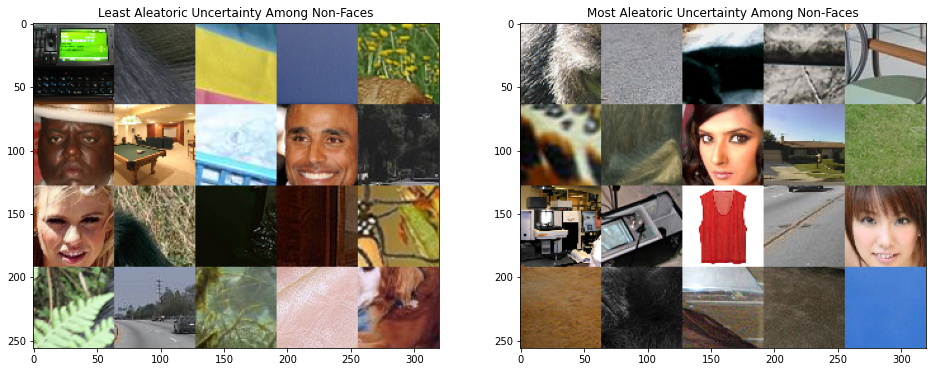

In [15]:
# Sort according to aleatoric uncertainty estimates
nonface_aleatoric_indices = np.argsort(nonface_aleatorics, axis=None) # sort the uncertainty values
aleatoric_nonface_images = nonface_images[nonface_aleatoric_indices] # sort images from lowest to highest uncertainty
sorted_aleatoric_nonfaces = [nonface_aleatorics[x] for x in nonface_aleatoric_indices] # order the uncertainty scores
sorted_aleatoric_nonface_preds = [nonface_predictions[x] for x in nonface_aleatoric_indices] # order the prediction values


# Visualize the 20 images with the LEAST and MOST aleatoric uncertainty
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(aleatoric_nonface_images[:20], (4, 5)))
ax[0].set_title("Least Aleatoric Uncertainty Among Non-Faces");

ax[1].imshow(mdl.util.create_grid_of_images(aleatoric_nonface_images[-20:], (4, 5)))
ax[1].set_title("Most Aleatoric Uncertainty Among Non-Faces");